In [1]:
import pandas as pd
import pickle
import numpy as np
import os
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import manhattan_distances
from scipy import spatial
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
current_dir = os.getcwd()
current_dir

'/Users/sam/Library/CloudStorage/OneDrive-Personale/Bank Customer Churn XAI Project/1) Bank Churn'

In [3]:

df = pd.read_csv(os.path.join(current_dir, 'df2_clean.csv'), index_col=0)
X_test = pd.read_csv(os.path.join(current_dir, 'Test_set.csv'), index_col=0)

# LightGBM CFs
explanations_DiCE = pd.read_csv(current_dir + '/CF generation datasets/explanations_DiCE.csv', index_col=0)
explanations_GS = pd.read_csv(current_dir + '/CF generation datasets/explanations_GS.csv', index_col=0)
explanations_CP_ILS = pd.read_csv(current_dir + '/CF generation datasets/explanations_CP_ILS.csv', index_col=0).round(0)
explanations_CFRL = pd.read_csv(current_dir + '/CF generation datasets/explanations_CFRL.csv', index_col=0)

# XGBoost CFs
'''explanations_DiCE = pd.read_csv(current_dir + '/CF generation datasets/explanations_DiCE_xgb.csv', index_col=0)
explanations_GS = pd.read_csv(current_dir + '/CF generation datasets/explanations_GS_xgb.csv', index_col=0)
explanations_CP_ILS = pd.read_csv(current_dir + '/CF generation datasets/explanations_CP_ILS_xgb.csv', index_col=0).round(0)
explanations_CFRL = pd.read_csv(current_dir + '/CF generation datasets/explanations_CFRL_xgb.csv', index_col=0)'''

"explanations_DiCE = pd.read_csv(current_dir + '/CF generation datasets/explanations_DiCE_xgb.csv', index_col=0)\nexplanations_GS = pd.read_csv(current_dir + '/CF generation datasets/explanations_GS_xgb.csv', index_col=0)\nexplanations_CP_ILS = pd.read_csv(current_dir + '/CF generation datasets/explanations_CP_ILS_xgb.csv', index_col=0).round(0)\nexplanations_CFRL = pd.read_csv(current_dir + '/CF generation datasets/explanations_CFRL_xgb.csv', index_col=0)"

In [4]:
# Load the model (trained with undersampling)

with open('lgb.pkl', 'rb') as file:
#with open('xgb.pkl', 'rb') as file:
    model = pickle.load(file)

#### Checking Validity

In [22]:
exps = [explanations_DiCE, explanations_GS, explanations_CP_ILS, explanations_CFRL]
exp_names = ['DiCE', 'GS', 'CP_ILS', 'CFRL']

for exp, name in zip(exps, exp_names):
    # Get the subset of X_test that matches the index of the current explanation DataFrame
    X_test_e = X_test.loc[list(exp.index)]

    # Make predictions on the original instances and the counterfactual instances
    y_pred_instances = model.predict(X_test_e)
    y_pred_cf = model.predict(exp)

    # Calculate the number of differing predictions
    differing_predictions = sum(y_pred_instances != y_pred_cf)

    # Calculate the total number of predictions
    total_predictions = len(y_pred_instances)

    # Calculate the percentage of differing predictions
    percentage_differing = (differing_predictions / total_predictions) * 100

    # Print the result
    print(f"Percentage of differing predictions for {name}: {percentage_differing:.2f}%")


Percentage of differing predictions for DiCE: 100.00%
Percentage of differing predictions for GS: 100.00%
Percentage of differing predictions for CP_ILS: 54.04%
Percentage of differing predictions for CFRL: 100.00%


In [9]:
index_difference_count_DiCE = len(set(explanations_DiCE.index) ^ set(X_test.index))
index_difference_count_GS = len(set(explanations_GS.index) ^ set(X_test.index))
index_difference_count_CP_ILS = len(set(explanations_CP_ILS.index) ^ set(X_test.index))
index_difference_count_CFRL = len(set(explanations_CFRL.index) ^ set(X_test.index))
print("Number of differing indices between explanations_DiCE and X_test:", index_difference_count_DiCE)
print("Number of differing indices between explanations_GS and X_test:", index_difference_count_GS)
print("Number of differing indices between explanations_CP_ILS and X_test:", index_difference_count_CP_ILS)
print("Number of differing indices between explanations_DiCE and X_test:", index_difference_count_CFRL)
print('GS vs CP_ILS differing indices', len(set(explanations_GS.index) ^ set(explanations_CP_ILS.index)))


Number of differing indices between explanations_DiCE and X_test: 0
Number of differing indices between explanations_GS and X_test: 179
Number of differing indices between explanations_CP_ILS and X_test: 0
Number of differing indices between explanations_DiCE and X_test: 0
GS vs CP_ILS differing indices 179


In [10]:
X_test.index.difference(explanations_CP_ILS.index)

Int64Index([], dtype='int64')

In [11]:
counts = explanations_GS.index.value_counts()

xx=0

repeated_indices = counts[counts > xx].index.tolist()
count_idx = len(repeated_indices)
if repeated_indices:
    print("Repeated indices:", count_idx)
else:
    print("No index is repeated more than {xx} times.")

Repeated indices: 1821


In [12]:
print(len(X_test))
print(len(explanations_DiCE))
print(len(explanations_GS))
print(len(explanations_CP_ILS))
print(len(explanations_CFRL))

2000
19888
6115
10010
20000


In [13]:
# Create an empty DataFrame with the same columns as explanations_DiCE (since it has all the indices)
ensemble_df = pd.DataFrame(columns=explanations_DiCE.columns)

# Get the unique index values from explanations_DiCE
unique_indices_DiCE= explanations_DiCE.index.unique()

# Iterate over the unique index values from explanations_DiCE
for index_value in unique_indices_DiCE:
    # Extract rows with the current index value from both DataFrames
    rows_DiCE = explanations_DiCE.loc[explanations_DiCE.index == index_value].copy()
    
    # Append rows from the second DataFrame (all available rows)
    rows_DiCE['source'] = 'DiCE'
    ensemble_df = pd.concat([ensemble_df, rows_DiCE], axis=0)
    
    # Check if corresponding rows exist in explanations_DiCE
    if index_value in explanations_CFRL.index.unique():
        # Extract all rows from the second DataFrame for the same index value
        rows_CFRL = explanations_CFRL.loc[explanations_CFRL.index == index_value]
        
        # Append all rows from the second DataFrame
        rows_CFRL['source'] = 'CFRL'
        ensemble_df = pd.concat([ensemble_df, rows_CFRL], axis=0)

    if index_value in explanations_CP_ILS.index.unique():
        # Extract all rows from the third DataFrame for the same index value
        rows_ILS = explanations_CP_ILS.loc[explanations_CP_ILS.index == index_value]
        
        # Append all rows from the third DataFrame with a new 'source' column indicating LORE
        rows_ILS['source'] = 'CP-ILS'
        ensemble_df = pd.concat([ensemble_df, rows_ILS], axis=0)
    
    if index_value in explanations_GS.index.unique():
        # Extract all rows from the third DataFrame for the same index value
        rows_GS = explanations_GS.loc[explanations_GS.index == index_value]
        
        # Append all rows from the third DataFrame with a new 'source' column indicating LORE
        rows_GS['source'] = 'GS'
        ensemble_df = pd.concat([ensemble_df, rows_GS], axis=0)


ensemble_df.rename(columns={'Unnamed: 0': 'original index'}, inplace=True)

/var/folders/lm/1vv1gxz56c5gjyw3q6_x350r0000gn/T/ipykernel_25809/3172686692.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_CFRL['source'] = 'CFRL'
/var/folders/lm/1vv1gxz56c5gjyw3q6_x350r0000gn/T/ipykernel_25809/3172686692.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_ILS['source'] = 'CP-ILS'
/var/folders/lm/1vv1gxz56c5gjyw3q6_x350r0000gn/T/ipykernel_25809/3172686692.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [14]:
cols_to_convert = ['CreditScore', 'Age', 'Gender', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
ensemble_df[cols_to_convert] = ensemble_df[cols_to_convert].astype('int64')

In [15]:
ensemble_df.dtypes

CreditScore            int64
Gender                 int64
Age                    int64
Tenure                 int64
Balance                int64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary        int64
Geography_encoded    float64
source                object
dtype: object

In [16]:
# Duplicate rows according to ensemble_df index
X_test_repeated = X_test.loc[list(ensemble_df.index)]

#### Filtering only valid CFs

In [17]:
# Filter ensemble to include only valid CFs, i.e. with differing predictions
y_pred_instances = model.predict(X_test_repeated)
y_pred_ensemble = model.predict(ensemble_df.iloc[:,:-1])
indices_differing = np.where(y_pred_instances != y_pred_ensemble)[0]
ensemble_df = ensemble_df.iloc[indices_differing]'''

'# Filter ensemble to include only valid CFs, i.e. with differing predictions\ny_pred_instances = model.predict(X_test_repeated)\ny_pred_ensemble = model.predict(ensemble_df.iloc[:,:-1])\nindices_differing = np.where(y_pred_instances != y_pred_ensemble)[0]\nensemble_df = ensemble_df.iloc[indices_differing]'

In [18]:
file_path = os.path.join(current_dir, 'ensemble_df.csv')
ensemble_df.to_csv(file_path, mode='w', index=True)

In [19]:
ensemble_df.shape

(56013, 11)

In [ ]:
# Re-index again X_test
X_test_repeated = X_test.loc[list(ensemble_df.index)]

In [ ]:
X_test_np = np.array(X_test_repeated)
cf_array = np.array(ensemble_df.iloc[:, :-1])
print(X_test_np.shape)
print(cf_array.shape)

In [ ]:
ensemble_df_new = ensemble_df.copy()

# Measure 1.1: Proximity - Overall difference in feature values (the average Euclidean distance between x and the counterfactual x')
#ensemble_df_new['Proximity'] = np.diag(cdist(cf_array, X_test_np))
ensemble_df_new['Proximity'] = np.sqrt(np.sum((cf_array - X_test_np)**2, axis=1))


# Measure 1.2: L1 norm - Overall difference in feature values (the average Manhattan distance between x and the counterfactual x')
ensemble_df_new['Proximity_L1'] = np.sum(np.abs(cf_array - X_test_np), axis=1)
                                       
# Measure 1.3: L∞ norm - the maximum of element-wise absolute difference btw the two vectors
ensemble_df_new['Proximity_L_inf'] = np.max(np.abs(cf_array - X_test_np), axis=1)

# Measure 2: Sparsity - Proportion of differing features %
#ensemble_df_new['Sparsity'] = np.diag(cdist(cf_array, X_test_np, metric='hamming'))
ensemble_df_new['Sparsity'] = np.sum(cf_array != X_test_np, axis=1) / X_test_np.shape[1]


In [ ]:
X_test_np.shape[1]

10

In [ ]:
# Measure 3: Plausibility - The average distance of x' from the closest instance in the X_test population 
#ensemble_df_new['Plausibility'] = np.min(cdist(cf_array, X_test_np), axis=1)

In [ ]:
# Measure 3 (Alternative): Plausibility - The average distance of x' from the closest instance in the X_test population 

# Build a KDTree on X_test_np
tree = spatial.KDTree(X_test_np)

# Query the KDTree to find the nearest neighbor in X_test_np for each instance in cf_array (mindist contains the distances to the nearest neighbors)
mindist, _ = tree.query(cf_array)

ensemble_df_new['Plausibility'] = mindist

In [ ]:
ensemble_df.iloc[:, :-1].shape

(51412, 10)

In [ ]:
X_test_np.shape

(51412, 10)

In [ ]:
ensemble_df_new.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_encoded,source,Proximity,Proximity_L1,Proximity_L_inf,Sparsity,Plausibility
5702,576,0,40,9,0,2,1,0,112465,0.5014,DiCE,18182.002777,18197.0,18182.0,0.4,99.403219
5702,576,0,59,9,0,2,1,0,112465,0.5014,DiCE,18182.016885,18216.0,18182.0,0.4,99.879928
5702,538,0,68,9,0,2,1,0,110440,0.5014,DiCE,16157.100173,16238.0,16157.0,0.4,258.151243
5702,560,0,50,3,0,2,1,0,84531,0.5014,DiCE,9752.042914,9795.0,9752.0,0.4,0.000000
5702,562,0,62,3,0,2,1,0,105986,0.5014,DiCE,11703.052166,11756.0,11703.0,0.4,0.000000


In [ ]:
l2_values = ensemble_df_new['Proximity'].values.reshape(-1, 1)
l1_values = ensemble_df_new['Proximity_L1'].values.reshape(-1, 1)
l_inf_values = ensemble_df_new['Proximity_L_inf'].values.reshape(-1, 1)
plausibility_values = ensemble_df_new['Plausibility'].values.reshape(-1, 1)

# Create a MinMaxScaler
min_max_scaler = MinMaxScaler()

# Fit and transform the proximity values
ensemble_df_new['Proximity_Normalized'] = min_max_scaler.fit_transform(l2_values)
ensemble_df_new['Proximity_L_1_Normalized'] = min_max_scaler.fit_transform(l1_values)
ensemble_df_new['Proximity_L_inf_Normalized'] = min_max_scaler.fit_transform(l_inf_values)
ensemble_df_new['Pausibility_Normalized'] = min_max_scaler.fit_transform(plausibility_values)
ensemble_df_new['AVG_Proximity'] = (
    ensemble_df_new['Proximity_Normalized'] *
    ensemble_df_new['Proximity_L_1_Normalized'] *
    ensemble_df_new['Proximity_L_inf_Normalized']
) ** (1 / 3)

ensemble_df_new = ensemble_df_new.drop(['Proximity', 'Plausibility','Proximity_L_inf', 'Proximity_L1','Proximity_Normalized', 'Proximity_L_1_Normalized', 'Proximity_L_inf_Normalized'], axis=1)

In [ ]:
ensemble_df_new.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_encoded,source,Sparsity,Pausibility_Normalized,AVG_Proximity
5702,576,0,40,9,0,2,1,0,112465,0.5014,DiCE,0.4,0.002788,0.056033
5702,576,0,59,9,0,2,1,0,112465,0.5014,DiCE,0.4,0.002801,0.056053
5702,538,0,68,9,0,2,1,0,110440,0.5014,DiCE,0.4,0.007239,0.049862
5702,560,0,50,3,0,2,1,0,84531,0.5014,DiCE,0.4,0.000000,0.030089
5702,562,0,62,3,0,2,1,0,105986,0.5014,DiCE,0.4,0.000000,0.036110


#### Diversity metric calculation

In [ ]:
diversity_cols = ensemble_df_new.iloc[:,:-3].copy()

In [ ]:
#V1
def calculate_diversity(df): # Mean of distances intra-group
    diversity_values = []
    for index, row in df.iterrows():
        source = row['source']
        group = df[(df['source'] == source) & (df.index == index)]
        if len(group) > 1:
            distances = pdist(group.iloc[:, :-1])  # Calculate distances within the same group
            diversity = np.mean(distances)
            diversity_values.append(diversity)
        else:
            diversity_values.append(np.nan) # if only 1 CF we can't caluclate diversity obv
    return diversity_values

# Add column 
diversity_cols['Diversity'] = calculate_diversity(diversity_cols)

In [ ]:
# Normalize Diversity and append it to ensemble_df_new
mean_pairwise_distance_values = diversity_cols['Diversity'].values.reshape(-1, 1)

ensemble_df_new['Diversity_Normalized'] = min_max_scaler.fit_transform(mean_pairwise_distance_values)

In [ ]:
# Fill NaN values for Diversity when only 1 CF was found (Diversity is equal 0 in that case)
ensemble_df_new.fillna(0, inplace=True)

In [ ]:
ensemble_df_new.to_csv('ensemble_df_new.csv', index=True)
#ensemble_df_new.to_csv('ensemble_df_new_xgb.csv', index=True)

### Import ensemble_df_new again from here

In [23]:
ensemble_df_new = pd.read_csv('ensemble_df_new.csv', index_col=0)
#ensemble_df_new = pd.read_csv('ensemble_df_new_xgb.csv', index_col=0)

In [24]:
# Define weights for the linear combination
w_dis_dist, w_dis_count, w_impl, w_div = 0.25, 0.25, 0.25, 0.25 
# Compute the linear combination score
ensemble_df_new['Linear Combination'] = (
    w_dis_dist * ensemble_df_new['AVG_Proximity'] +   # TO BE MINIMIZED
    w_dis_count * ensemble_df_new['Sparsity'] +     # TO BE MINIMIZED
    w_impl * ensemble_df_new['Pausibility_Normalized'] +   # TO BE MINIMIZED
    w_div * (1-ensemble_df_new['Diversity_Normalized'])   # COMPLEMENT TO BE MINIMIZED
)

In [ ]:
#ensemble_df_new.set_index(ensemble_df_new['index'], inplace=True)
#ensemble_df_new.drop('index', inplace=True, axis=1)

In [25]:
# Sort the DataFrame by 'Linear Combination' in asc order
ensemble_df_new_sorted = ensemble_df_new.sort_values(by='Linear Combination', ascending=True)

# Group by index and select the top 5 rows for each group  
# Result is 5 top CFs per index so for example for 1000 original instances --> 5000 rows

top_5_per_index = ensemble_df_new_sorted.groupby(level=0).head(5)
print(top_5_per_index.shape)

# Sort it
top_5_per_index_sorted = top_5_per_index.sort_index()


print(len(top_5_per_index_sorted[top_5_per_index_sorted.source=='DiCE'])) 
print(len(top_5_per_index_sorted[top_5_per_index_sorted.source=='GS']))
print(len(top_5_per_index_sorted[top_5_per_index_sorted.source=='CP-ILS']))
print(len(top_5_per_index_sorted[top_5_per_index_sorted.source=='CFRL']))

(10000, 16)
6509
2624
861
6


In [26]:
print(len(ensemble_df_new[ensemble_df_new.source=='DiCE'])) 
print(len(ensemble_df_new[ensemble_df_new.source=='GS']))
print(len(ensemble_df_new[ensemble_df_new.source=='CP-ILS']))
print(len(ensemble_df_new[ensemble_df_new.source=='CFRL']))

19888
6115
5409
20000


In [27]:
# Adding Predicted Churn to Raw Ensemble(Not ground truth from y_test)
y_pred = model.predict(ensemble_df_new.iloc[:,:-6].values)
ensemble_df_new['churn'] = y_pred

In [28]:
# Define different weight combinations
weight_combinations = [
    {'w_dis_dist': 0.5, 'w_dis_count': 1/6, 'w_impl': 1/6, 'w_div': 1/6}, #higher weight to proximity
    {'w_dis_dist': 1/6, 'w_dis_count': 0.5, 'w_impl': 1/6, 'w_div': 1/6}, #higher weight to sparsity
    {'w_dis_dist': 1/6, 'w_dis_count': 1/6, 'w_impl': 0.5, 'w_div': 1/6}, #higher weight to plausibility
    {'w_dis_dist': 1/6, 'w_dis_count': 1/6, 'w_impl': 1/6, 'w_div': 0.5}, #higher weight to diversity
    {'w_dis_dist': 0.25, 'w_dis_count': 0.25, 'w_impl': 0.25, 'w_div': 0.25} #equal weights
    
]

# Loop through different weight combinations
for weights in weight_combinations:
    
    ensemble_df_copy = ensemble_df_new.copy()

    # Compute the linear combination score
    ensemble_df_copy['Linear Combination'] = (
        weights['w_dis_dist'] * ensemble_df_copy['AVG_Proximity'] +
        weights['w_dis_count'] * ensemble_df_copy['Sparsity'] +
        weights['w_impl'] * ensemble_df_copy['Pausibility_Normalized'] +
        weights['w_div'] * (1-(ensemble_df_copy['Diversity_Normalized']))
    )
    
    # Sort the DataFrame by 'Linear Combination' in asc order: ### The lower the score the better ###
    ensemble_df_copy_sorted = ensemble_df_copy.sort_values(by='Linear Combination', ascending=True)

    # Group by index and select the top 5 rows for each group
    top_5_per_index = ensemble_df_copy_sorted.groupby(level=0).head(5)

    # Sort it 
    top_5_per_index_sorted = top_5_per_index.sort_index()

    '''# Print and store the results
    print(f"Weights: {weights}")
    print("DiCE:", len(top_5_per_index_sorted[top_5_per_index_sorted.source == 'DiCE']))
    print("GS:", len(top_5_per_index_sorted[top_5_per_index_sorted.source == 'GS']))
    print("ILS:", len(top_5_per_index_sorted[top_5_per_index_sorted.source == 'CP-ILS']))
    print("CFRL:", len(top_5_per_index_sorted[top_5_per_index_sorted.source == 'CFRL']))'''

In [ ]:
'''# Find the differences between the two DataFrames
differences = X_test.loc[5702, :] != top_5_per_index_sorted.loc[5702].iloc[1, :-6]

# Extract the changed features
changed_features = X_test.columns[differences]

# Display the changed features
print("Changed Features:")
print(changed_features)

# Display the original and new values for the changed features
comparison_df = pd.DataFrame({
    'Original': X_test.loc[5702, changed_features].values,
    'New': top_5_per_index_sorted.loc[5702].iloc[0, :-6][changed_features].values
})

print("\nComparison of Original and New Values for Changed Features:")
print(comparison_df)
'''

'# Find the differences between the two DataFrames\ndifferences = X_test.loc[5702, :] != top_5_per_index_sorted.loc[5702].iloc[1, :-6]\n\n# Extract the changed features\nchanged_features = X_test.columns[differences]\n\n# Display the changed features\nprint("Changed Features:")\nprint(changed_features)\n\n# Display the original and new values for the changed features\ncomparison_df = pd.DataFrame({\n    \'Original\': X_test.loc[5702, changed_features].values,\n    \'New\': top_5_per_index_sorted.loc[5702].iloc[0, :-6][changed_features].values\n})\n\nprint("\nComparison of Original and New Values for Changed Features:")\nprint(comparison_df)\n'

In [ ]:
# Adding Predicted Churn to Top 5 (Not ground truth from y_test)
y_pred = model.predict(top_5_per_index_sorted.iloc[:,:-7].values)
top_5_per_index_sorted['churn'] = y_pred

In [ ]:
# Save Ensemble_top_5_CFs

file_path = 'top_5_per_index_sorted.csv'
#file_path = 'top_5_per_index_sorted_xgb.csv'
#top_5_per_index_sorted.to_csv(file_path, mode='w', index=True)

In [ ]:
# Define the color palette
colorblind_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#A72528']

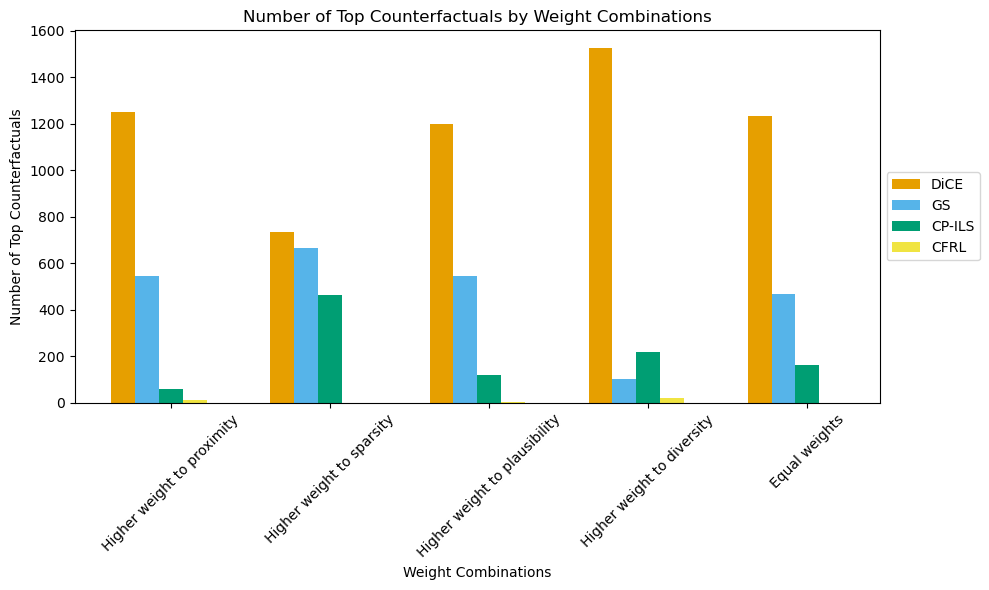

In [ ]:
# Define weight combinations with labels
weight_combinations_labeled = [
    {'label': 'Higher weight to proximity', 'weights': {'w_dis_dist': 0.5, 'w_dis_count': 1/6, 'w_impl': 1/6, 'w_div': 1/6}},
    {'label': 'Higher weight to sparsity', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 0.5, 'w_impl': 1/6, 'w_div': 1/6}},
    {'label': 'Higher weight to plausibility', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 1/6, 'w_impl': 0.5, 'w_div': 1/6}},
    {'label': 'Higher weight to diversity', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 1/6, 'w_impl': 1/6, 'w_div': 0.5}},
    {'label': 'Equal weights', 'weights': {'w_dis_dist': 0.25, 'w_dis_count': 0.25, 'w_impl': 0.25, 'w_div': 0.25}}
]

# Initialize counts dictionary
counts = {'DiCE': [], 'GS': [], 'CP-ILS': [], 'CFRL': []}

# Loop through different weight combinations
for weights_info in weight_combinations_labeled:
    weights = weights_info['weights']
    #ensemble_df_copy = ensemble_df_new.copy()
    ensemble_df_copy = ensemble_df_new[ensemble_df_new['churn']==0].copy()
    ensemble_df_copy['Linear Combination'] = (
        weights['w_dis_dist'] * ensemble_df_copy['AVG_Proximity'] +
        weights['w_dis_count'] * ensemble_df_copy['Sparsity'] +
        weights['w_impl'] * ensemble_df_copy['Pausibility_Normalized'] +
        weights['w_div'] * (1-ensemble_df_copy['Diversity_Normalized'])
    )
    ensemble_df_copy_sorted = ensemble_df_copy.sort_values(by='Linear Combination', ascending=True)
    top_5 = ensemble_df_copy_sorted.groupby(level=0).head(5)
    top_5_sorted = top_5.sort_index()
    # Store the counts for each algorithm
    for algo in counts.keys():
        counts[algo].append(len(top_5_sorted[top_5_sorted.source == algo]))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions
x = range(len(weight_combinations_labeled))

# Bar width
width = 0.15

# Plot bars for each algorithm
for i, (algo, data) in enumerate(counts.items()):
    ax.bar([pos + i*width for pos in x], data, width, label=algo, color=colorblind_palette[i % len(colorblind_palette)])

# Set labels and title
ax.set_xlabel('Weight Combinations')
ax.set_ylabel('Number of Top Counterfactuals')
ax.set_title('Number of Top Counterfactuals by Weight Combinations')
ax.set_xticks([pos + 2*width for pos in x])
ax.set_xticklabels([info['label'] for info in weight_combinations_labeled])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#ensemble_df_new.to_csv('ensemble_df_new.csv', mode='w', index=True)

#### Assigning black-box probabilities to each CF

In [31]:
# Predict probabilities
predicted_probabilities = model.predict_proba(ensemble_df_new.iloc[:,:-7])

# Get the max of the two proba
max_proba = np.max(predicted_probabilities, axis=1)

# Create a column in ensemble_df_new to store the associated probabilities
ensemble_df_new['prediction_proba'] = max_proba

In [ ]:
#np.max(model.predict_proba(ensemble_df_new.iloc[0,:-6].values.reshape(1, -1)))

#### Filter is first on linear combination and then on treshold (ignore this)

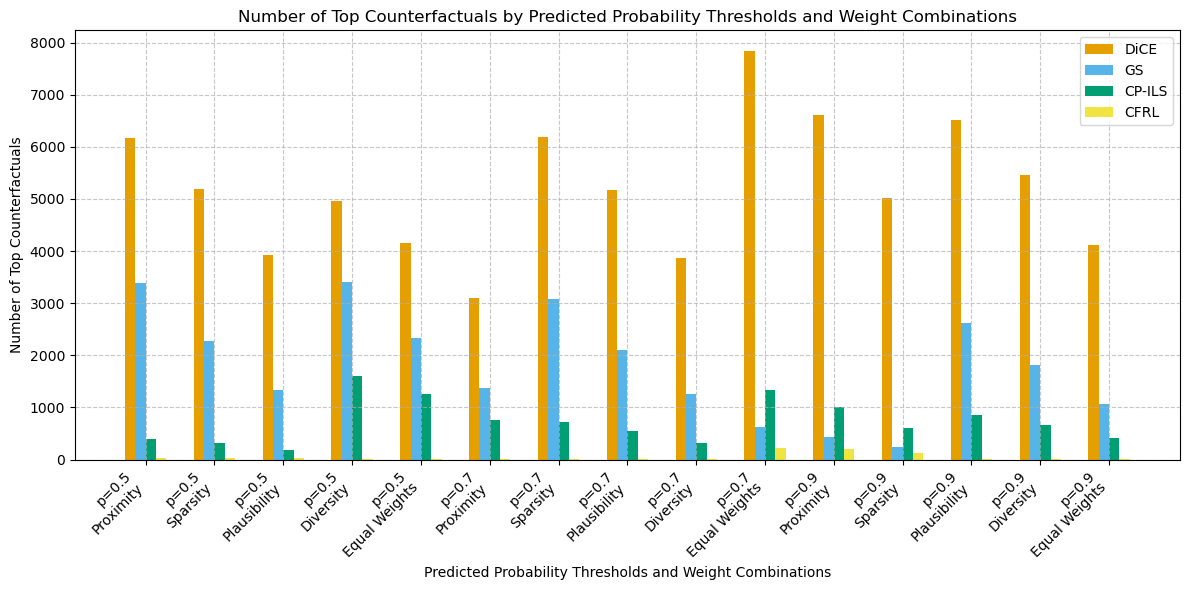

In [ ]:
# Define weight combinations with labels
weight_combinations_labeled = [
    {'label': 'Proximity', 'weights': {'w_dis_dist': 0.5, 'w_dis_count': 1/6, 'w_impl': 1/6, 'w_div': 1/6}},
    {'label': 'Sparsity', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 0.5, 'w_impl': 1/6, 'w_div': 1/6}},
    {'label': 'Plausibility', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 1/6, 'w_impl': 0.5, 'w_div': 1/6}},
    {'label': 'Diversity', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 1/6, 'w_impl': 1/6, 'w_div': 0.5}},
    {'label': 'Equal Weights', 'weights': {'w_dis_dist': 0.25, 'w_dis_count': 0.25, 'w_impl': 0.25, 'w_div': 0.25}}
]

# Define predicted_proba thresholds
predicted_proba_thresholds = [0.5, 0.7, 0.9]  

# Initialize counts dictionary
counts = {'DiCE': [], 'GS': [], 'CP-ILS': [], 'CFRL': []}

# Loop through different weight combinations and predicted_proba thresholds
for weights_info in weight_combinations_labeled:
    weights = weights_info['weights']
    for threshold in predicted_proba_thresholds:
        ensemble_df_copy = ensemble_df_new.copy()
        ensemble_df_copy['Linear Combination'] = (
            weights['w_dis_dist'] * ensemble_df_copy['AVG_Proximity'] +
            weights['w_dis_count'] * ensemble_df_copy['Sparsity'] +
            weights['w_impl'] * ensemble_df_copy['Pausibility_Normalized'] +
            weights['w_div'] * (1-ensemble_df_copy['Diversity_Normalized'])
        )
        ensemble_df_copy_sorted = ensemble_df_copy.sort_values(by='Linear Combination', ascending=True)
        top_5 = ensemble_df_copy_sorted.groupby(level=0).head(5)
        top_5_sorted = top_5.sort_index()
        # Filter by predicted_proba threshold
        top_5_sorted = top_5_sorted[top_5_sorted['prediction_proba'] >= threshold]
        # Store the counts for each algorithm
        for algo in counts.keys():
            counts[algo].append(len(top_5_sorted[top_5_sorted.source == algo]))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar positions
x = range(len(predicted_proba_thresholds) * len(weight_combinations_labeled))

# Bar width
width = 0.15

# Plot bars for each algorithm
for i, (algo, data) in enumerate(counts.items()):
    ax.bar([pos + i*width for pos in x], data, width, label=algo, color=colorblind_palette[i % len(colorblind_palette)])

# Set labels and title
ax.set_xlabel('Predicted Probability Thresholds and Weight Combinations')
ax.set_ylabel('Number of Top Counterfactuals')
ax.set_title('Number of Top Counterfactuals by Predicted Probability Thresholds and Weight Combinations')

# Set x-axis ticks and labels
ax.set_xticks([pos + 1.5*width for pos in range(len(x))])
ax.set_xticklabels(
    [f"p={threshold}\n{info['label']}" for threshold in predicted_proba_thresholds for info in weight_combinations_labeled], 
    rotation=45, ha='right'
)

# Ensure all labels are displayed
plt.xticks(rotation=45, ha='right')


# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend(loc='upper right')#, bbox_to_anchor=(1, 0.5))

# Show plot
plt.tight_layout()
plt.show()


#### Below, the first filter is based on probabilities threshold and then on Linear Combination score

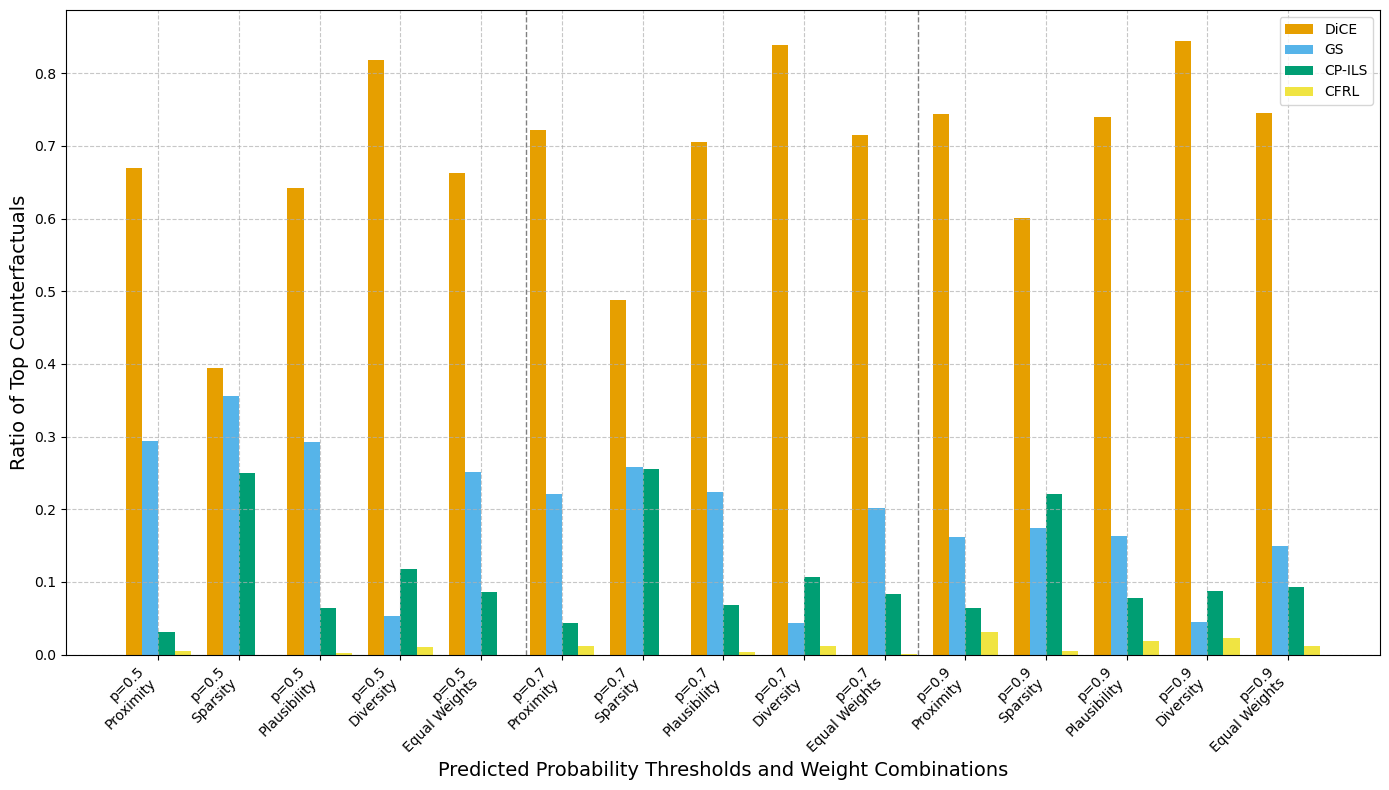

In [ ]:
# Define weight combinations with labels
weight_combinations_labeled = [
    {'label': 'Proximity', 'weights': {'w_dis_dist': 0.5, 'w_dis_count': 1/6, 'w_impl': 1/6, 'w_div': 1/6}},
    {'label': 'Sparsity', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 0.5, 'w_impl': 1/6, 'w_div': 1/6}},
    {'label': 'Plausibility', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 1/6, 'w_impl': 0.5, 'w_div': 1/6}},
    {'label': 'Diversity', 'weights': {'w_dis_dist': 1/6, 'w_dis_count': 1/6, 'w_impl': 1/6, 'w_div': 0.5}},
    {'label': 'Equal Weights', 'weights': {'w_dis_dist': 0.25, 'w_dis_count': 0.25, 'w_impl': 0.25, 'w_div': 0.25}}
]

# Define predicted_proba thresholds
predicted_proba_thresholds = [0.5, 0.7, 0.9] 

# Initialize counts dictionary
counts = {'DiCE': [], 'GS': [], 'CP-ILS': [], 'CFRL': []}

# Loop through different predicted_proba thresholds first
for threshold in predicted_proba_thresholds:
    for weights_info in weight_combinations_labeled:
        weights = weights_info['weights']
        #ensemble_df_copy = ensemble_df_new.copy()
        ensemble_df_copy = ensemble_df_new[ensemble_df_new['churn']==0].copy() #Change to only display churners/non churners
        
        # Filter by predicted_proba threshold
        ensemble_df_copy = ensemble_df_copy[ensemble_df_copy['prediction_proba'] >= threshold]
        
        # Calculate linear combination score
        ensemble_df_copy['Linear Combination'] = (
            weights['w_dis_dist'] * ensemble_df_copy['AVG_Proximity'] +
            weights['w_dis_count'] * ensemble_df_copy['Sparsity'] +
            weights['w_impl'] * ensemble_df_copy['Pausibility_Normalized'] +
            weights['w_div'] * (1 - ensemble_df_copy['Diversity_Normalized'])
        )
        ensemble_df_copy_sorted = ensemble_df_copy.sort_values(by='Linear Combination', ascending=True)
        # Group by index and get top 5 counterfactuals based on linear combination score
        top_5_per_index = ensemble_df_copy_sorted.groupby(level=0).head(5)
        
        # Count the ratio of top counterfactuals for each algorithm
        for algo in counts.keys():
            counts[algo].append(len(top_5_per_index[top_5_per_index.source == algo])/len(top_5_per_index))

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Bar positions
x = range(len(predicted_proba_thresholds) * len(weight_combinations_labeled))

# Bar width
width = 0.2

# Plot bars for each algorithm 
for i, (algo, data) in enumerate(counts.items()):
    ax.bar([pos + i*width for pos in x], data, width, label=algo, color=colorblind_palette[i % len(colorblind_palette)])

# Set labels and title
ax.set_xlabel('Predicted Probability Thresholds and Weight Combinations',fontsize=14)
ax.set_ylabel('Ratio of Top Counterfactuals',fontsize=14)
#ax.set_title('Number of Top Counterfactuals by Predicted Probability Thresholds and Weight Combinations')

# Set x-axis ticks and labels
ax.set_xticks([pos + 1.5*width for pos in range(len(x))])
ax.set_xticklabels(
    [f"p={threshold}\n{info['label']}" for threshold in predicted_proba_thresholds for info in weight_combinations_labeled], 
    rotation=45, ha='right'
)

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend(loc='upper right')#, bbox_to_anchor=(1, 0.5))

# Putting vertical lines to separate different threshold sections
for i in range(1, len(predicted_proba_thresholds)):
    ax.axvline(x=len(weight_combinations_labeled) * (len(counts)+0.86) * i * width, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
#plt.savefig('NonChurners.png')
plt.show()

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [ ]:

# Group by 'source' column and calculate stats
stats_by_source = ensemble_df_new.groupby('source')[['Pausibility_Normalized', 'AVG_Proximity', 'Sparsity', 'Diversity_Normalized', 'prediction_proba']].agg(['mean', 'median', 'std', 'min', 'max'])

# Display stats
#print(stats_by_source)

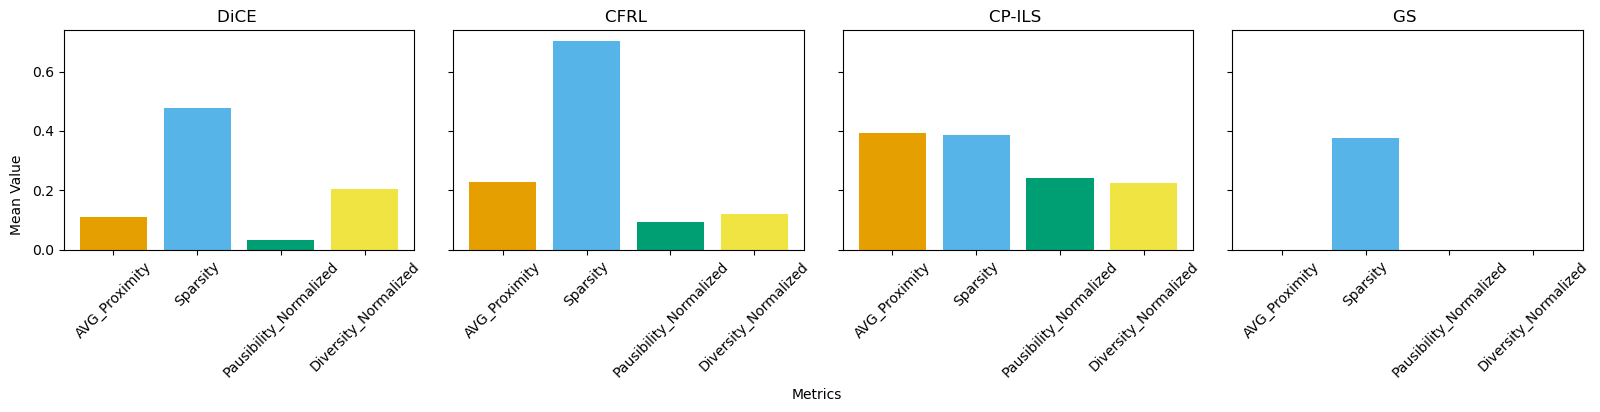

In [ ]:
source_data = ensemble_df_new['source'].unique()

# Create subplots 
fig, axs = plt.subplots(1, len(source_data), figsize=(16, 4), sharey=True)
palette = colorblind_palette
for i, source in enumerate(source_data):
    source_data_df = ensemble_df_new[ensemble_df_new['source'] == source]

    # Calculate the mean values for each column
    avg_proximity_mean = source_data_df['AVG_Proximity'].mean()
    sparsity_mean = source_data_df['Sparsity'].mean()
    pausibility_normalized_mean = source_data_df['Pausibility_Normalized'].mean()
    diversity_normalized_mean = source_data_df['Diversity_Normalized'].mean()

    # Plot the mean values in the current subplot
    axs[i].bar(['AVG_Proximity', 'Sparsity', 'Pausibility_Normalized', 'Diversity_Normalized'], 
               [avg_proximity_mean, sparsity_mean, pausibility_normalized_mean, diversity_normalized_mean], 
               color=palette)
    axs[i].set_title(f'{source} ')
    axs[i].tick_params(axis='x', rotation=45)

# Set common ylabel and adjust layout
fig.text(0.5, 0, 'Metrics', ha='center', va='center')
fig.text(0, 0.5, 'Mean Value', ha='center', va='center', rotation='vertical')
plt.tight_layout()

# Show plot
plt.show()



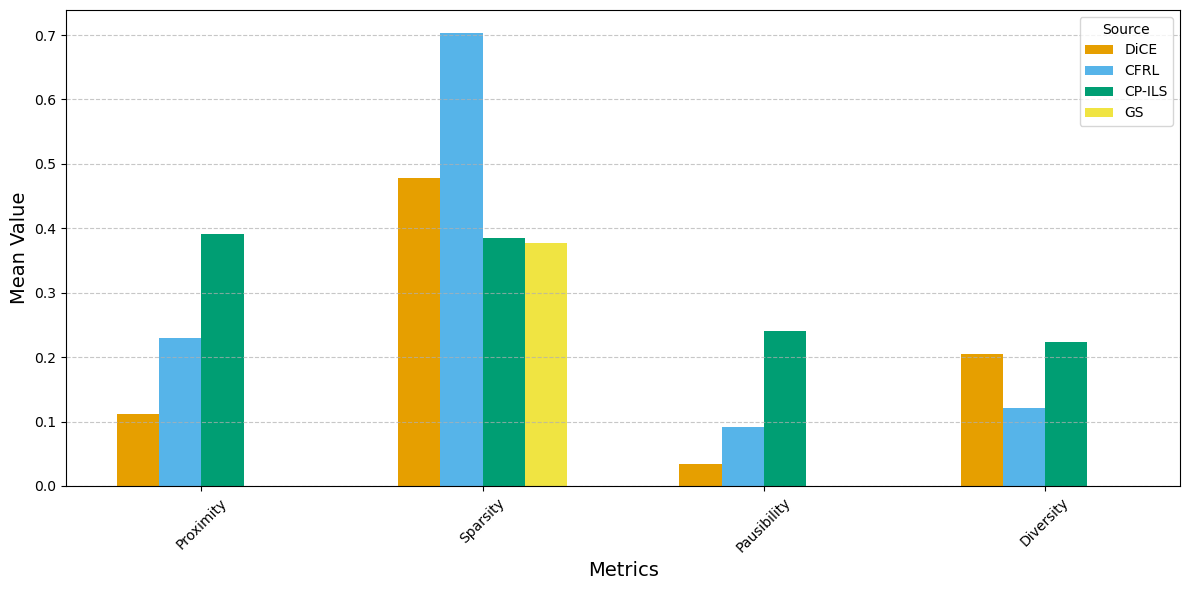

In [ ]:
# Define the sources and the metrics
source_data = ensemble_df_new['source'].unique()
metrics = ['AVG_Proximity', 'Sparsity', 'Pausibility_Normalized', 'Diversity_Normalized']
labels = ['Proximity', 'Sparsity', 'Pausibility', 'Diversity']

# Calculate mean values for each source and metric
mean_values = ensemble_df_new.groupby('source')[metrics].mean().T

# Create a grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define the number of bars and their positions
num_sources = len(source_data)
bar_width = 0.15
positions = list(range(len(metrics)))

# Plot bars for each source
for i, source in enumerate(source_data):
    values = mean_values[source].values
    bar_positions = [pos + i * bar_width for pos in positions]
    ax.bar(bar_positions, values, bar_width, label=source, color=colorblind_palette[i])

# Set the x-axis labels and positions
ax.set_xticks([pos + bar_width * (num_sources / 2) - bar_width / 2 for pos in positions])
ax.set_xticklabels(labels, rotation=45)

# Set common labels and title
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Mean Value', fontsize=14)
#ax.set_title('Mean Values of Metrics by Source', fontsize=16)

ax.legend(title='Source', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Analysis of prediction probas of top k vs raw ensemble. We see almost no change in mean prediction probabilities of the balck box from top k ensemble to raw ensemble

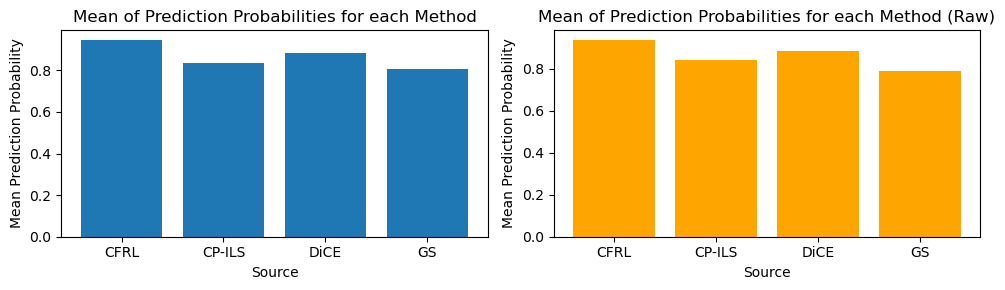

In [ ]:
# Predict probabilities
predicted_probabilities = model.predict_proba(top_5_per_index_sorted.iloc[:,:-7])

# Get the max of the two proba
max_proba = np.max(predicted_probabilities, axis=1)

# Create a column in ensemble_df_new to store the associated probabilities
top_5_per_index_sorted['prediction_proba'] = max_proba

group = top_5_per_index_sorted.groupby('source')['prediction_proba'].mean()
group_std = top_5_per_index_sorted.groupby('source')['prediction_proba'].std()
#print(group)
#print(group_std) 

group_raw = ensemble_df_new.groupby('source')['prediction_proba'].mean()
group_raw_std = ensemble_df_new.groupby('source')['prediction_proba'].std()
#print(group_raw)
#print(group_raw_std)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the first 
axs[0].bar(group.index, group.values)
axs[0].set_xlabel('Source')
axs[0].set_ylabel('Mean Prediction Probability')
axs[0].set_title('Mean of Prediction Probabilities for each Method')
# Plot the second
axs[1].bar(group_raw.index, group_raw.values, color='orange')
axs[1].set_xlabel('Source')
axs[1].set_ylabel('Mean Prediction Probability')
axs[1].set_title('Mean of Prediction Probabilities for each Method (Raw)')

plt.tight_layout()
plt.show()

#### Columns Change-Ratio

In [34]:
ensemble_slice = ensemble_df_new.iloc[:,:-8].copy()

def calculate_change_ratios(explanations, X_test):
    change_ratios = {}
    
    # Iterate over each column in the explanations
    for column in explanations.columns:
        column_change_ratios = []
        
        # Iterate over each index in explanations
        for idx in pd.unique(explanations.index):
            row = X_test.loc[idx, column]
            # Get the corresponding value of the current column in explanations for the current index
            rows = explanations.loc[idx, column].tolist()
            if not isinstance(rows, list):
                rows = [rows]  # Ensure it is a list even if just a single row
            # Calculate the count of changes
            change_count = sum(row != r for r in rows)
            # Calculate the ratio of changes
            cf_rows = len(rows)
            change_ratio = change_count / cf_rows
            # Store the change ratio for the current index
            column_change_ratios.append(change_ratio)
        
        # Store the change ratios for the current column
        change_ratios[column] = column_change_ratios
    
    return change_ratios

# Calculate change ratios for each method
change_ratios_CP_ILS = calculate_change_ratios(explanations_CP_ILS, X_test)
change_ratios_CFRL = calculate_change_ratios(explanations_CFRL, X_test)
change_ratios_GS = calculate_change_ratios(explanations_GS, X_test)
change_ratios_DiCE = calculate_change_ratios(explanations_DiCE, X_test)
change_ratios_ensemble = calculate_change_ratios(ensemble_df_new.iloc[:,:-8].copy(), X_test)

In [35]:
# Make it a DataFrame
change_ratios_cp_ils = pd.DataFrame.from_dict(change_ratios_CP_ILS)
# Get average change of that feature in CFs dataset
mean_values_cp_ils = change_ratios_cp_ils.mean()

change_ratios_cfrl = pd.DataFrame.from_dict(change_ratios_CFRL)
mean_values_cfrl = change_ratios_cfrl.mean()

change_ratios_dice = pd.DataFrame.from_dict(change_ratios_DiCE)
mean_values_dice = change_ratios_dice.mean()

change_ratios_gs = pd.DataFrame.from_dict(change_ratios_GS)
mean_values_gs = change_ratios_gs.mean()

change_ratios_ensemble = pd.DataFrame.from_dict(change_ratios_ensemble)
mean_values_ensemble = change_ratios_ensemble.mean()

In [37]:
!pip install ace_tools

ERROR: Could not find a version that satisfies the requirement ace_tools (from versions: none)
ERROR: No matching distribution found for ace_tools


In [43]:
mean_values_df = pd.DataFrame({
    'T-LACE': mean_values_cp_ils,
    'CFRL': mean_values_cfrl,
    'DiCE': mean_values_dice,
    'GS': mean_values_gs,
    'Ensemble': mean_values_ensemble
})

mean_values_df.round(2)

,T-LACE,CFRL,DiCE,GS,Ensemble
CreditScore,0.32,1.00,1.00,0.21,0.84
Gender,0.04,0.36,0.02,0.24,0.17
Age,0.25,0.95,0.95,0.24,0.81
Tenure,0.23,0.94,0.74,0.24,0.71
Balance,0.30,1.00,0.64,0.30,0.71
NumOfProducts,0.25,0.42,0.36,0.73,0.42
HasCrCard,0.14,0.30,0.02,0.26,0.16
IsActiveMember,0.09,0.11,0.05,0.40,0.12
EstimatedSalary,1.00,1.00,1.00,0.20,0.91
Geography_encoded,1.00,1.00,0.01,1.00,0.61


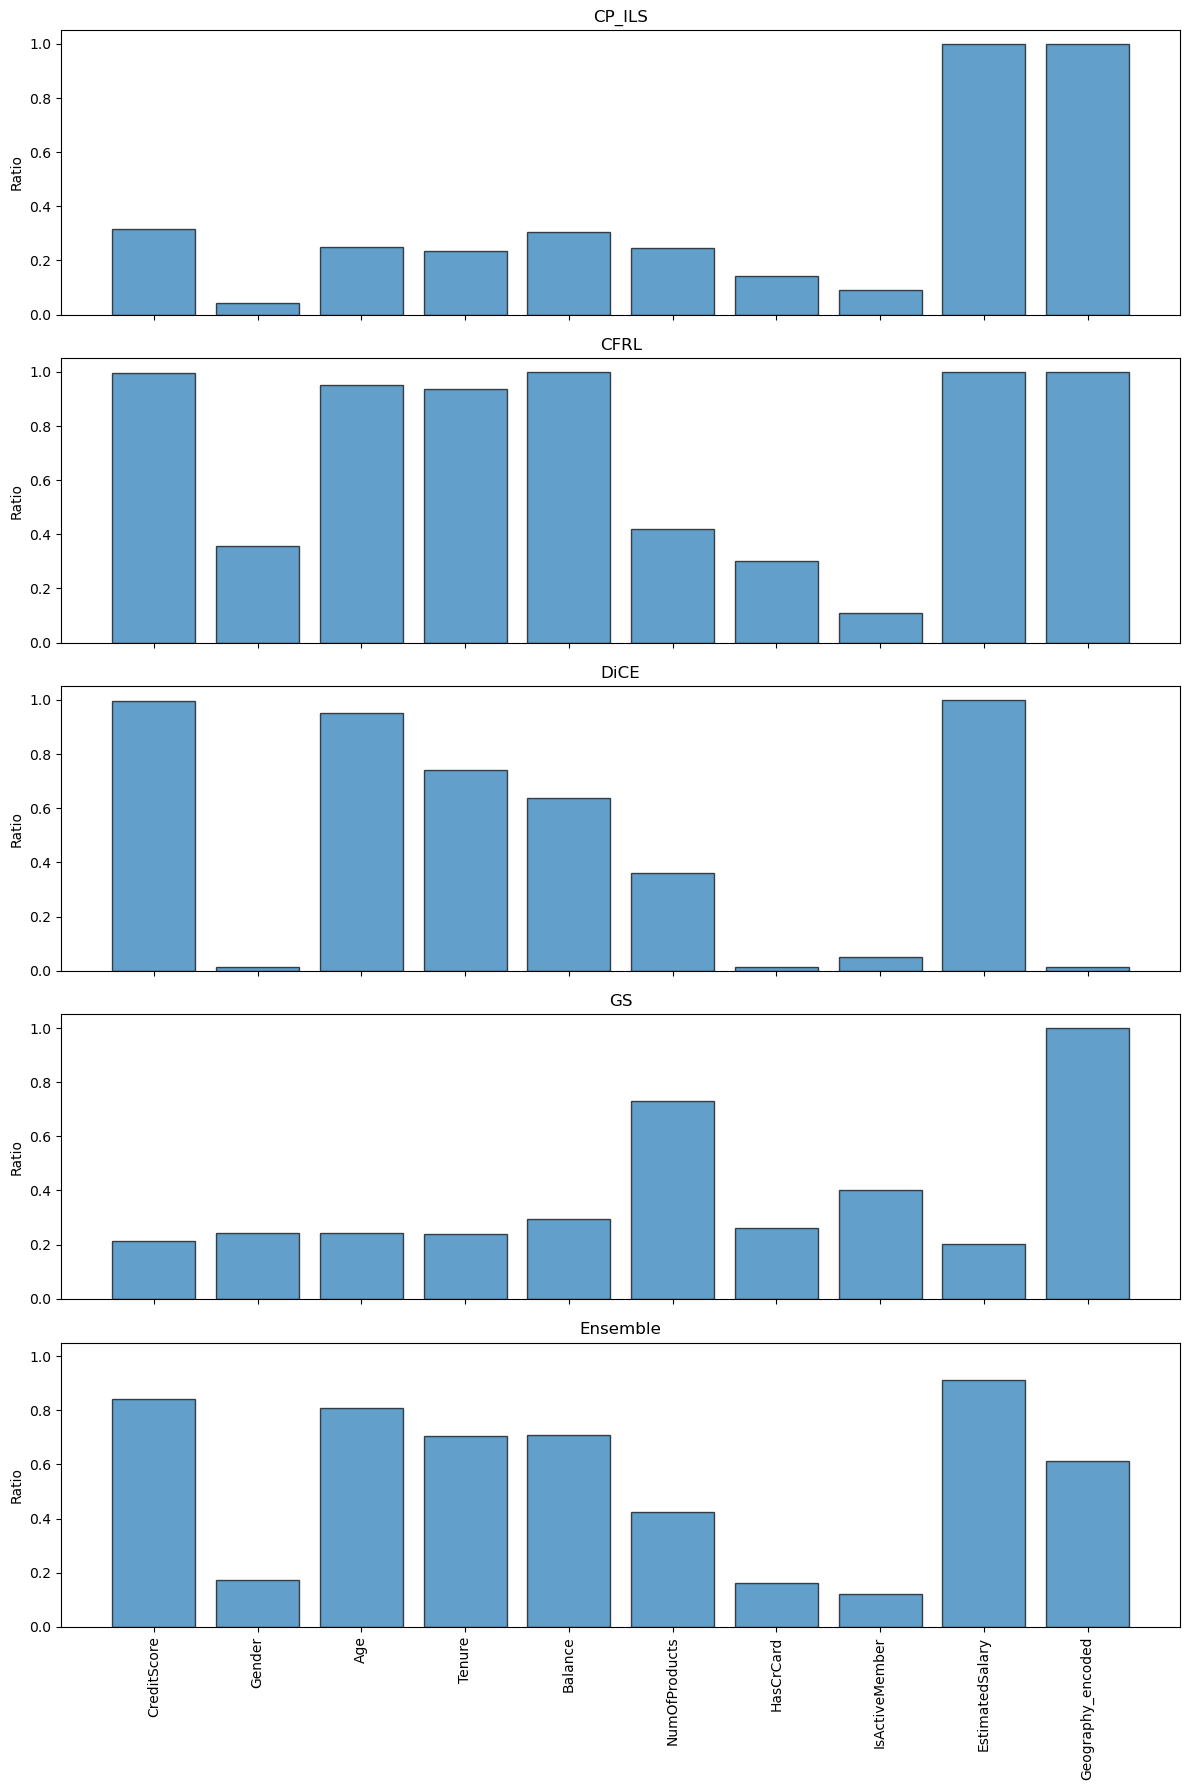

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(12, 18), sharex=True, sharey=True)

# Plot histograms for CP_ILS
axs[0].bar(mean_values_cp_ils.index, mean_values_cp_ils.values, alpha=0.7, edgecolor='black')
axs[0].set_ylabel('Ratio')
axs[0].set_title('CP_ILS')

# Plot histograms for CFRL
axs[1].bar(mean_values_cfrl.index, mean_values_cfrl.values, alpha=0.7, edgecolor='black')
axs[1].set_ylabel('Ratio')
axs[1].set_title('CFRL')

# Plot histograms for DiCE
axs[2].bar(mean_values_dice.index, mean_values_dice.values, alpha=0.7, edgecolor='black')
axs[2].set_ylabel('Ratio')
axs[2].set_title('DiCE')

# Plot histograms for GS
axs[3].bar(mean_values_gs.index, mean_values_gs.values, alpha=0.7, edgecolor='black')
axs[3].set_ylabel('Ratio')
axs[3].set_title('GS')

# Plot histograms for ensemble_df_new
axs[4].bar(mean_values_ensemble.index, mean_values_ensemble.values, alpha=0.7, edgecolor='black')
axs[4].set_ylabel('Ratio')
axs[4].set_title('Ensemble')

# Set common xlabel and rotate tick labels
plt.xticks(rotation=90)
#plt.xlabel('Columns')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Calculate std of each column that has been changed from original instance

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the X_test dataframe
scaler = StandardScaler()
X_test_standardized = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

# Standardize the explanations datasets similarly
def standardize_explanations(explanations, scaler, columns):
    standardized_data = scaler.transform(explanations)
    return pd.DataFrame(standardized_data, columns=columns, index=explanations.index)

explanations_CP_ILS_standardized = standardize_explanations(explanations_CP_ILS, scaler, X_test.columns)
explanations_CFRL_standardized = standardize_explanations(explanations_CFRL, scaler, X_test.columns)
explanations_GS_standardized = standardize_explanations(explanations_GS, scaler, X_test.columns)
explanations_DiCE_standardized = standardize_explanations(explanations_DiCE, scaler, X_test.columns)
ensemble_slice_standardized = standardize_explanations(ensemble_slice, scaler, X_test.columns)

In [ ]:
def calculate_std_devs(explanations, X_test):
    std_devs = {}
    
    # Iterate over each column in the test set
    for column in X_test.columns:
        column_std_dev = []
        
        # Iterate over each index in the explanations
        for idx in pd.unique(explanations.index):
            
            # Get the original value from X_test
            original_value = X_test.loc[idx, column]

            # Get the values for the current index and column
            values = explanations.loc[idx, column].tolist()
            
            if not isinstance(values, list):
                values = [values]

            # Calculate the differences between original_value and values
            differences = [np.abs(original_value - value) for value in values]
            
            # Calculate the standard deviation
            std_dev = np.std(differences)
            
            # Store the standard deviation for the current index
            column_std_dev.append(std_dev)
        
        # Store the standard deviations for the current column
        std_devs[column] = column_std_dev
    
    return std_devs

# Calculate standard deviations for each method
std_devs_CP_ILS = calculate_std_devs(explanations_CP_ILS, X_test)
std_devs_CFRL = calculate_std_devs(explanations_CFRL, X_test)
std_devs_GS = calculate_std_devs(explanations_GS, X_test)
std_devs_DiCE = calculate_std_devs(explanations_DiCE, X_test)
std_devs_ensemble = calculate_std_devs(ensemble_slice, X_test)

# Convert the std to DataFrames and calculate mean values
std_devs_cp_ils = pd.DataFrame.from_dict(std_devs_CP_ILS)
mean_std_devs_cp_ils = std_devs_cp_ils.mean()

std_devs_cfrl = pd.DataFrame.from_dict(std_devs_CFRL)
mean_std_devs_cfrl = std_devs_cfrl.mean()

std_devs_gs = pd.DataFrame.from_dict(std_devs_GS)
mean_std_devs_gs = std_devs_gs.mean()

std_devs_dice = pd.DataFrame.from_dict(std_devs_DiCE)
mean_std_devs_dice = std_devs_dice.mean()

std_devs_ensemble = pd.DataFrame.from_dict(std_devs_ensemble)
mean_std_devs_ensemble = std_devs_ensemble.mean()

In [ ]:
mean_std_devs_gs

CreditScore          0.172443
Gender               0.166440
Age                  0.172091
Tenure               0.176222
Balance              0.174426
NumOfProducts        0.119642
HasCrCard            0.171598
IsActiveMember       0.175861
EstimatedSalary      0.160770
Geography_encoded    0.036593
dtype: float64

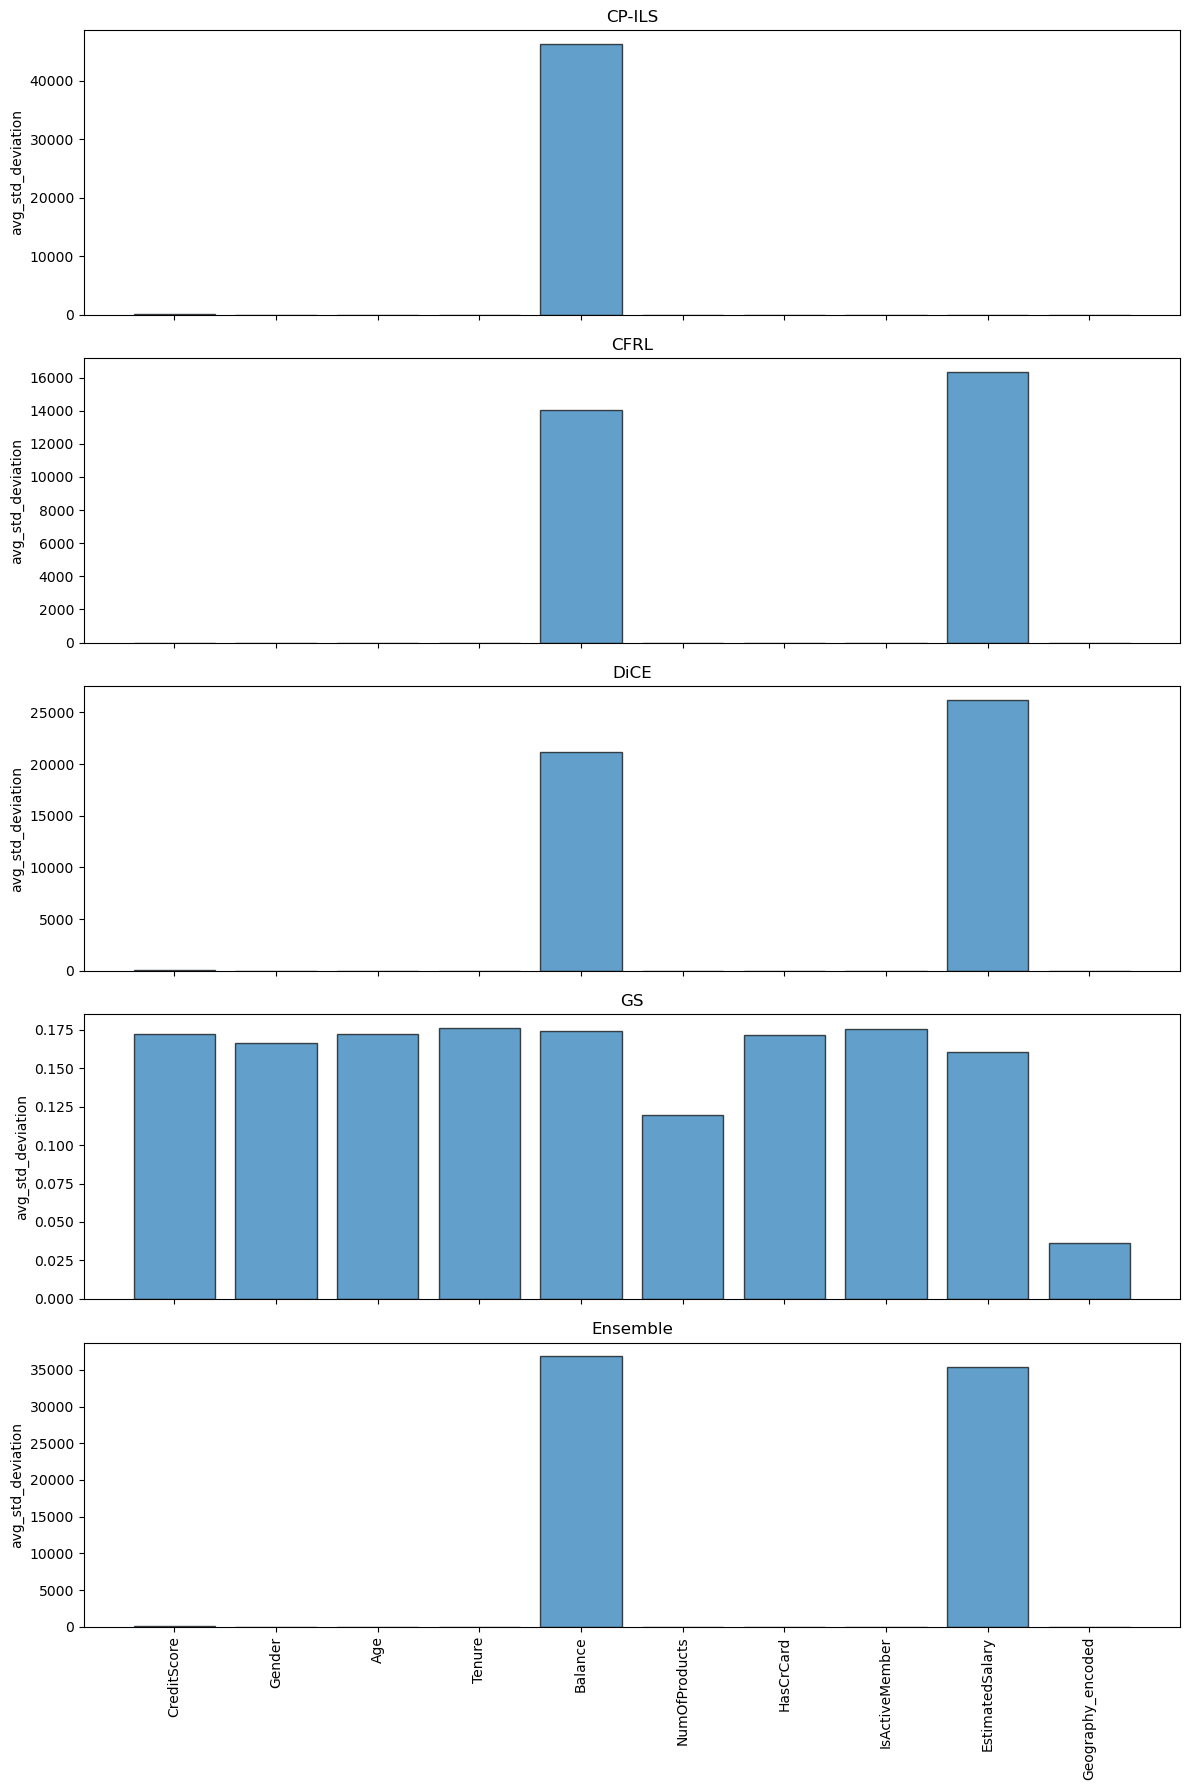

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(12, 18), sharex=True)

# Plot histograms for CP-ILS
axs[0].bar(mean_std_devs_cp_ils.index, mean_std_devs_cp_ils.values, alpha=0.7, edgecolor='black')
axs[0].set_ylabel('avg_std_deviation')
axs[0].set_title('CP-ILS')

# Plot histograms for CFRL
axs[1].bar(mean_std_devs_cfrl.index, mean_std_devs_cfrl.values, alpha=0.7, edgecolor='black')
axs[1].set_ylabel('avg_std_deviation')
axs[1].set_title('CFRL')

# Plot histograms for DiCE
axs[2].bar(mean_std_devs_dice.index, mean_std_devs_dice.values, alpha=0.7, edgecolor='black')
axs[2].set_ylabel('avg_std_deviation')
axs[2].set_title('DiCE')

# Plot histograms for GS
axs[3].bar(mean_std_devs_gs.index, mean_std_devs_gs.values, alpha=0.7, edgecolor='black')
axs[3].set_ylabel('avg_std_deviation')
axs[3].set_title('GS')

# Plot histograms for Ensemble
axs[4].bar(mean_std_devs_ensemble.index, mean_std_devs_ensemble.values, alpha=0.7, edgecolor='black')
axs[4].set_ylabel('avg_std_deviation')
axs[4].set_title('Ensemble')

# Set common xlabel and rotate tick labels
plt.xticks(rotation=90)
#plt.xlabel('Features')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Compare columns with SHAP

In [ ]:
import shap

In [ ]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


##### the SHAP values for the positive class (churners). They represent the contribution of each feature to the prediction that the instance belongs to the positive class. A positive SHAP value for a feature in this context means that the feature increases the likelihood of the instance being classified as churner, whereas a negative SHAP value means it decreases this likelihood.

In [ ]:
shap_values_positive = shap_values[1]
feature_names = X_test.columns

# Get the mean absolute SHAP values for each feature
shap_importance = pd.DataFrame(list(zip(X_test.columns, np.mean(np.abs(shap_values_positive), axis=0))), columns=['features', 'importance'])

# Sort features by importance
shap_importance = shap_importance.sort_values(by='importance', ascending=False)
shap_importance.head()

,features,importance
2,Age,2.168035
5,NumOfProducts,1.865274
7,IsActiveMember,1.790380
9,Geography_encoded,1.668279
4,Balance,0.706956


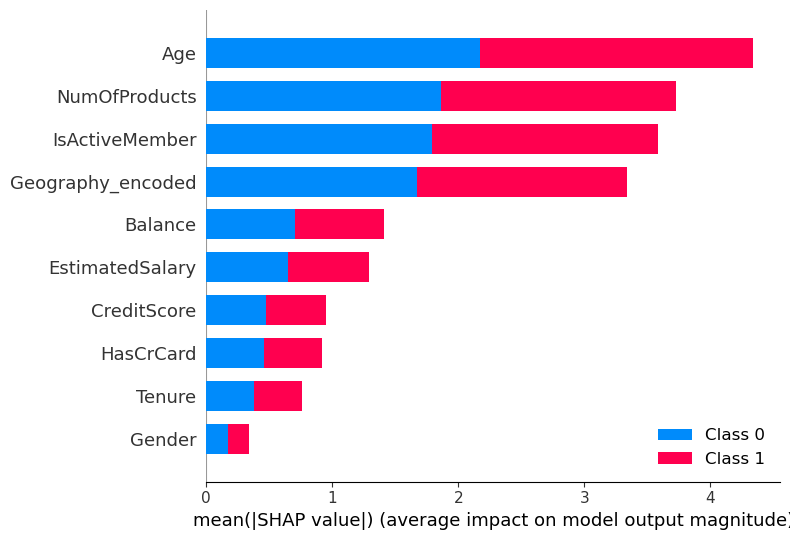

In [ ]:
shap.summary_plot(shap_values, X_test.columns)

In [ ]:
shap_values_negative = shap_values[0]
feature_names = X_test.columns

# Get the mean absolute SHAP values for each feature
shap_importance_neg = pd.DataFrame(list(zip(X_test.columns, np.mean(np.abs(shap_values_negative), axis=0))), columns=['features', 'importance'])

# Sort features by importance
shap_importance_neg = shap_importance_neg.sort_values(by='importance', ascending=False)
shap_importance_neg.head()

,features,importance
2,Age,2.168035
5,NumOfProducts,1.865274
7,IsActiveMember,1.790380
9,Geography_encoded,1.668279
4,Balance,0.706956


In [ ]:
# Highest Change ratio columns to be compared to SHAP values
mean_values_ensemble.nlargest()

In [ ]:
# Normalize the importance values
shap_importance['normalized_importance'] = shap_importance['importance'] / shap_importance['importance'].sum()
shap_importance.drop('importance', axis=1, inplace=True)
shap_importance.head() 

,features,normalized_importance
2,Age,0.209876
5,NumOfProducts,0.180567
7,IsActiveMember,0.173317
9,Geography_encoded,0.161497
4,Balance,0.068437


In [ ]:
# Select an instance to explain
instance_index = 1997
instance = X_test.iloc[instance_index]

# Visualize SHAP values for the single instance
#shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values_positive[instance_index], instance, feature_names=[f'Feature {i}' for i in range(X_test.shape[1])])

##### The model predict this instance to churn, we want to see what are the features that push towards the opposite prediction

In [ ]:
print('class prediction: ', model.predict(X_test.iloc[1997].values.reshape(1, -1)))
print('class probas: ', model.predict_proba(X_test.iloc[1997].values.reshape(1, -1))[0])

class prediction:  [1]
class probas:  [0.00179102 0.99820898]


##### For example lets check the SHAP Value for Age for Class 1:

    If the SHAP value is positive, the specific Age value increases the likelihood of predicting class 1.
    If the SHAP value is negative, the specific Age value decreases the likelihood of predicting class 1.

In [ ]:
# SHAP values for the selected instance
shap_values_instance = shap_values_positive[instance_index]

# Create a DataFrame
shap_df = pd.DataFrame({
    'SHAP Value': shap_values_instance,
    'Feature Value': instance
})

# Sort the DataFrame by absolute SHAP value
shap_df_instance = shap_df.sort_values(by='SHAP Value', ascending=False)

shap_df_instance

,SHAP Value,Feature Value
Age,3.442263,47.0000
IsActiveMember,1.386252,0.0000
NumOfProducts,0.908652,1.0000
HasCrCard,0.807708,0.0000
CreditScore,0.643667,516.0000
EstimatedSalary,0.122619,149614.0000
Gender,-0.144439,1.0000
Balance,-0.237220,128298.0000
Geography_encoded,-0.380857,0.2509
Tenure,-0.865502,9.0000


### Studying ways to apply recourse costs

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
top_5_per_index_sorted = pd.read_csv('top_5_per_index_sorted.csv', index_col=0)
# Add probabilities again...
predicted_probabilities = model.predict_proba(top_5_per_index_sorted.iloc[:,:-7])

# Get the max of the two proba
max_proba = np.max(predicted_probabilities, axis=1)

# Create a column in ensemble_df_new to store the associated probabilities
top_5_per_index_sorted['prediction_proba'] = max_proba

In [ ]:
binary_columns = ['Gender', 'HasCrCard', 'IsActiveMember']
cols = [i for i in X_test.columns if i not in binary_columns]
scaler = MinMaxScaler()

In [ ]:
X_test_repeated = X_test.loc[list(top_5_per_index_sorted.index)]
X_test_repeated.shape

(10000, 10)

In [ ]:
scaler.fit(X_test_repeated[cols])
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_repeated[cols]), columns=cols, index=X_test_repeated.index)

In [ ]:
recourse_df = top_5_per_index_sorted[cols]
scaler.fit(recourse_df[cols])
recourse_scaled = pd.DataFrame(scaler.fit_transform(recourse_df[cols]), columns=cols, index=recourse_df.index)

In [ ]:
# Combine the scaled continuous columns with the binary columns for X_test
X_test_scaled = pd.concat([X_test_scaled, X_test_repeated[binary_columns]], axis=1)

# Combine the scaled continuous columns with the binary columns and Cost for recourse_df
recourse_scaled = pd.concat([recourse_scaled, top_5_per_index_sorted[binary_columns]], axis=1)

In [ ]:
X_test_np = np.array(X_test_scaled)
cf_array = np.array(recourse_scaled) ### The top 5 CF ensemble

In [ ]:
# Associated cost weights from 1 to 10 i.e. pre-defined set of difficulty to achieve a change

weights = {
    'CreditScore': 8,
    'Gender': 1e10,                
    'Age': 1e10,                   
    'Tenure': 7,
    'Balance': 6,
    'NumOfProducts': 1,
    'HasCrCard': 1,
    'IsActiveMember': 1,
    'EstimatedSalary': 8,
    'Geography_encoded': 10
} 

In [ ]:
# Make it an array
weights_array = np.array([weights['CreditScore'], weights['Gender'], weights['Age'],
                          weights['Tenure'], weights['Balance'], weights['NumOfProducts'],
                          weights['HasCrCard'], weights['IsActiveMember'], weights['EstimatedSalary'],
                          weights['Geography_encoded']])


# Calculate the weighted Euclidean distance as Cost
recourse_scaled['Cost'] = np.sqrt(np.sum(weights_array * (cf_array - X_test_np)**2, axis=1))

In [ ]:
cost_min = recourse_scaled['Cost'].min()
cost_max = recourse_scaled['Cost'].max()
recourse_scaled['Normalized_Cost'] = (recourse_scaled['Cost'] - cost_min) / (cost_max - cost_min)
recourse_scaled.drop(['Cost'], axis=1, inplace=True)

In [ ]:
top_5_per_index_sorted = pd.concat([top_5_per_index_sorted, recourse_scaled['Normalized_Cost']], axis=1)

In [ ]:
costs = top_5_per_index_sorted.groupby('source').agg('Normalized_Cost').mean()
costs

source
CFRL     0.177
CP-ILS   0.147
DiCE     0.293
GS       0.057
Name: Normalized_Cost, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

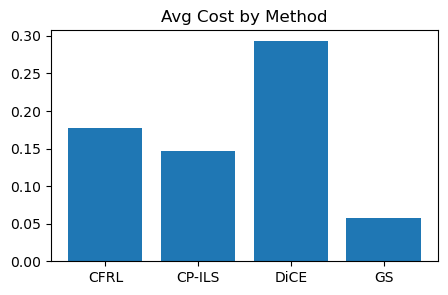

In [ ]:
plt.figure(figsize=(5, 3))
plt.bar(costs.index, costs.values)
plt.title('Avg Cost by Method')
plt.show

In [ ]:
filtr = top_5_per_index_sorted['prediction_proba']>0.85
top_5_per_index_sorted[filtr]['Normalized_Cost'].mean()

0.23032623685716536

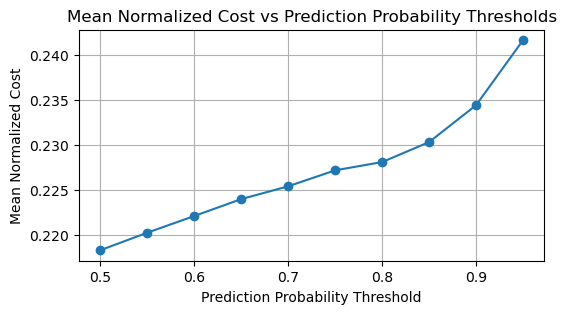

In [ ]:
# Create the range of thresholds
thresholds = np.arange(0.5, 1.05, 0.05)

# Calculate the mean Normalized_Cost for each threshold
means = []
for thres in thresholds:
    filtr = top_5_per_index_sorted['prediction_proba'] > thres
    mean_cost = top_5_per_index_sorted[filtr]['Normalized_Cost'].mean()
    means.append(mean_cost)

# Plot the results
plt.figure(figsize=(6, 3))
plt.plot(thresholds, means, marker='o')
plt.title('Mean Normalized Cost vs Prediction Probability Thresholds')
plt.xlabel('Prediction Probability Threshold')
plt.ylabel('Mean Normalized Cost')
plt.grid(True)
plt.show()

#### Now focusing on a single instance 

In [ ]:
r = 9

In [ ]:
# Extract the feature values for the specified rows
cf_values = top_5_per_index_sorted.loc[r].iloc[0,:-9].values #choosing the CF with the lowest Cost
original_values = X_test.loc[r].values

cf_values = cf_values.astype(float)
original_values = original_values.astype(float)

# Calculate the weighted Euclidean distance for each feature as Cost
weighted_distances = np.sqrt(weights_array * (cf_values - original_values)**2)

# DataFrame to store the results
results_df = pd.DataFrame({
    'Feature': top_5_per_index_sorted.columns[:-9],
    'Cost': weighted_distances
})

In [ ]:
# Rank of intervention based on Lowest Cost (if Cost is zero no change has been made to the feature)
results_df[results_df['Cost']>0].sort_values(by='Cost', ascending=True)

,Feature,Cost
3,Tenure,2.646
0,CreditScore,183.848
8,EstimatedSalary,2098.693
4,Balance,8188.644
2,Age,3000000.000


In [ ]:
concatenated_df = pd.concat([X_test.loc[r], top_5_per_index_sorted.loc[r].iloc[0,:-9]], axis=1)
print(concatenated_df.to_string())

                           9       9
CreditScore          684.000     619
Gender                 0.000       0
Age                   27.000      57
Tenure                 2.000       3
Balance           134603.000  137946
NumOfProducts          1.000       1
HasCrCard              1.000       1
IsActiveMember         1.000       1
EstimatedSalary    71725.000   72467
Geography_encoded      0.501   0.501


In [ ]:
X_test.index.get_loc(r)

1032

In [ ]:
# SHAP values for the selected instance
shap_values_instance = shap_values_positive[1032]
# Create a DataFrame
shap_df = pd.DataFrame({
    'SHAP Value': shap_values_instance,
    'Feature Value': original_values
})

# Sort the DataFrame by absolute SHAP value
shap_df_instance = shap_df.sort_values(by='SHAP Value', ascending=False)

shap_df_instance

,SHAP Value,Feature Value
5,1.045,1.000
4,0.218,134603.000
8,-0.087,71725.000
6,-0.100,1.000
1,-0.190,0.000
0,-0.205,684.000
3,-0.272,2.000
7,-1.713,1.000
9,-2.210,0.501
2,-2.350,27.000
